In [1]:
# initial setup
#%run "../../../common/0_notebooks_base_setup.py"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

opcion_reducida = True

<link rel="stylesheet" href="../../../common/dhds.css">
<div class="Table">
    <div class="Row">
        <div class="Cell grey left"> <img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_47_Text_Mining_2/Presentacion/img/M6_CLASE_47_portada.jpg" align="center" width="90%"/></div>        
        <div class="Cell right">
            <div class="div-logo"><img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/common/logo_DH.png" align="center" width=70% /></div>
            <div class="div-curso">DATA SCIENCE</div>
            <div class="div-modulo">MÓDULO 6</div>
            <div class="div-contenido">Text Minig <br/> Clasificación de texto</div>
        </div>
    </div>
</div>

## Agenda

---

- Análisis de sentimientos como problema de clasificación

- Clasificación

- N-gramas


<div class="div-dhds-fondo-1"> Introducción
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_47_Text_Mining_2/Presentacion/img/M6_CLASE_47_separador.png" align="center" />

</div>


## Introducción

---

<table><tr><td style="font-size:14px;width:55%;line-height:2;">El análisis de sentimientos es una técnica a través de la cual podemos analizar un fragmento de texto para determinar el sentimiento detrás de él. 
<br/>
Combina el aprendizaje automático y el procesamiento del lenguaje natural (NLP) para lograrlo. 
<br/>
Podemos pensar este problema como un problema de clasificación, donde las features son generadas con el técnicas de preprocesamiento de texto que vimos la clase pasada.</td><td><img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_47_Text_Mining_2/Presentacion/img/M6_CLASE_47_intro.jpg" align="center"/></td></tr></table>

<div class="div-dhds-fondo-1"> Clasificación
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_47_Text_Mining_2/Presentacion/img/M6_CLASE_47_separador.png" align="center" />

</div>


## Clasificación

---

En esta clase analizaremos un dataset de reviews de imdb (http://ai.stanford.edu/~amaas/data/sentiment/) usando regresión logística para predecir a partir del texto del comentario si la calificación otorgada por el usuario es positiva o negativa.


### Datos

---

Los datos están separados en dos archivos, uno de train y uno de test, cada uno con la misma cantidad de registros.

Las clases están balanceadas tanto en el dataset de train como en el de test, es decir, hay igual cantidad de reviews positivas y negativas.


In [3]:
train_file_path = '../Data/imdb_train.zip'
data_train = pd.read_csv(train_file_path, sep="\t")
data_train

if opcion_reducida:
    data_train = data_train.sample(int (data_train.shape[0]/4))

data_train.head()

,text,label
8883,This is a great example of a rather simple Fil...,1
10896,Always enjoy the great acting of Drew Barrymor...,1
23118,This show is unbelievable in that . . . what i...,0
21351,This was god awful. The story was all over the...,0
15922,this is the worst movie i've ever seen. i'm no...,0


In [4]:
data_train.label.value_counts()

1    3138
0    3112
Name: label, dtype: int64

In [5]:
test_file_path = '../Data/imdb_test.zip'
data_test = pd.read_csv(test_file_path, sep="\t")
data_test

if opcion_reducida:
    data_test = data_test.sample(int (data_test.shape[0]/4))

In [6]:
data_test.label.value_counts()

0    3133
1    3117
Name: label, dtype: int64

### Imports

In [7]:
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

### Preparación

---

Limpiamos los datos de train y de test:

* usamos un tokennizer que elimine los signos de puntuación y tags html

* hacemos stemming para obtener las raíces de las palabras en minúsculas

* eliminamos stopwords

In [8]:
def clean_review(review_text, tokenizer, stemmer, stopwords):    
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(review_text)
    #print(words)
    
    # stemming: raiz y minúsculas:
    stem_words = [stemmer.stem(x) for x in words]
    #print(stem_words)
    
    # eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    #print(clean_words)
    
    result = " ".join(clean_words)
    
    return(result)
    

Ejemplo sobre un registro de train 

In [9]:

review_text = data_train.text.iloc[1]

print("antes: ", review_text)

#eliminamos todos los signos de puntuación
tokenizer = RegexpTokenizer(r"\w+")

englishStemmer = SnowballStemmer("english")
stopwords_en = stopwords.words('english');
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

review_text_clean = clean_review(review_text, tokenizer, englishStemmer, stopwords_en_stem)


antes:  Always enjoy the great acting of Drew Barrymore and her great performance in this film, where she plays a very very complicated young gal,(Holly Gooding),"Skipped Parts",2000, who leaves New York and travels to California and shares an apartment with a up and coming writer, George Newbern,(Patrick Highsmith),"Far Harbor",'96. Many strange things start to happen to Holly and she seeks to find her brother in a mental institution after he killed her father. If you look close enough you will actually see the mother of Drew Barrymore in real life appear as her mother in this picture. If it was not for the good acting of Drew Barrymore and George Newbern, this film should be seen only on Halloween Night! However, it sure has it's surprises in the END!!!!


In [10]:
print("---")
print("después: ", review_text_clean)


---
después:  alway enjoy great act drew barrymor great perform film play complic young gal holli good skip part 2000 leav new york travel california share apart come writer georg newbern patrick highsmith far harbor 96 mani strang thing start happen holli seek find brother mental institut kill father look close enough actual see mother drew barrymor real life appear mother pictur good act drew barrymor georg newbern film seen halloween night howev sure surpris end


Procesamos todos los registros de los datasets de train y test

In [11]:
clean_train = [clean_review(x, tokenizer, englishStemmer, stopwords_en_stem) for x in data_train.text]
#clean_train[0:5]

In [12]:
clean_test = [clean_review(x, tokenizer, englishStemmer, stopwords_en_stem) for x in data_test.text]
#clean_test[0:5]


Usando `CountVectorizer` vamos a transformar los datos de train y test

In [13]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(clean_train)
X_train_sparse = count_vectorizer.transform(clean_train)
X_test_sparse = count_vectorizer.transform(clean_test)

In [14]:
temp = X_test_sparse.todense()

In [18]:
X_train = pd.DataFrame(X_train_sparse.todense(), 
             columns = count_vectorizer.get_feature_names_out()) 
y_train = data_train.label

In [17]:
X_test = pd.DataFrame(X_test_sparse.todense(), 
             columns = count_vectorizer.get_feature_names_out()) 
y_test = data_test.label

In [22]:
X_test

,00,000,001,007,0080,0083,00am,00s,01,02,...,ángela,är,ääliöt,élan,émigré,était,état,êxtase,über,üvegtigri
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Modelo

---

Vamos a usar ahora una regresión logística para predecir el valor de `label`

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Veamos qué valor de `C` (regularización) resulta en un modelo de mejor performance

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Valores más pequeños de `C` implican regularización más fuerte.

In [20]:
X_train_train, X_train_val, y_train_train, y_train_val = \
    train_test_split(X_train, y_train, train_size = 0.75, shuffle = True, random_state = 147)
"""
for c in [0.005, 0.008, 0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c, solver="newton-cg", penalty="l2")    
    lr.fit(X_train_train, y_train_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_train_val, lr.predict(X_train_val))))
""" 

'\nfor c in [0.005, 0.008, 0.01, 0.05, 0.25, 0.5, 1]:    \n    lr = LogisticRegression(C=c, solver="newton-cg", penalty="l2")    \n    lr.fit(X_train_train, y_train_train)\n    print ("Accuracy for C=%s: %s" \n           % (c, accuracy_score(y_train_val, lr.predict(X_train_val))))\n'

Entrenamos el modelo final

In [21]:
final_model = LogisticRegression(C = 0.05, solver="newton-cg", penalty="l2")
final_model.fit(X_train, y_train)
print ("Final Accuracy: %s" 
        % accuracy_score(y_test, final_model.predict(X_test)))
print ("Final Confusion Matrix: \n %s" 
        % confusion_matrix(y_test, final_model.predict(X_test)))

Final Accuracy: 0.86368
Final Confusion Matrix: 
 [[2668  465]
 [ 387 2730]]


Observemos cuáles son las 3 palabras más discriminantes tanto positiva como negativamente. 

Para ver esto, veremos cuáles son las palabras (features) asociadas a los coeficientes máximos y mínimos de la regresión logística.

Construyamos un dataframe de dos columnas:

* word: cada registro tiene un nombre que corresponde a una feature del modelo (las palabras en el corpus)
* coef: cada registro tiene un valor que es el coeficiente de la regresión logística para su feature

Y ordenemos el dataframe según los valores de coef de forma descendente.


In [23]:
feature_to_coef = pd.DataFrame(columns = ['word', 'coef'])
feature_to_coef.word = count_vectorizer.get_feature_names_out()
feature_to_coef.coef = final_model.coef_[0]
feature_to_coef_sort_desc = feature_to_coef.sort_values(by = 'coef', ascending = False)
positive_words = feature_to_coef_sort_desc.word[0:3]
positive_words

8500       excel
18609    perfect
10595      great
Name: word, dtype: object

In [24]:
feature_to_coef_sort_asc = feature_to_coef.sort_values(by = 'coef', ascending = True)
negative_words = feature_to_coef_sort_asc.word[0:3]
negative_words

27710    worst
27134     wast
3313      bore
Name: word, dtype: object

Grafiquemos estos resultados para ver cómo se distribuyen los valores

In [25]:
columns =  np.concatenate([positive_words.values, negative_words.values])
columns

array(['excel', 'perfect', 'great', 'worst', 'wast', 'bore'], dtype=object)

In [26]:
data_plot = X_train.loc[:, columns]
y_train_r = y_train.reset_index(drop=True)
#data_plot.reset_index(inplace = True)
data_plot["label"] = y_train_r

In [27]:
data_plot

,excel,perfect,great,worst,wast,bore,label
0,1,0,2,0,0,0,1
1,0,0,2,0,0,0,1
2,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
6245,0,0,1,0,0,0,1
6246,0,0,0,0,1,1,0
6247,0,0,0,0,0,0,0
6248,0,0,1,0,0,0,0


In [28]:
data_plot_long = pd.melt(data_plot, 
                         id_vars = ["label"], 
                         #value_vars = data_plot.columns[1:len(data_plot.columns)-1], 
                         var_name = "word", value_name = "value")
#data_plot_long["word_label"] = data_plot_long.word + ["_" + str(x) for x in data_plot_long.label]  
data_plot_long

,label,word,value
0,1,excel,1
1,1,excel,0
2,0,excel,0
3,0,excel,1
4,0,excel,0
...,...,...,...
37495,1,bore,0
37496,0,bore,1
37497,0,bore,0
37498,0,bore,0


In [29]:
data_plot_long['value'].value_counts()

0    33390
1     3264
2      609
3      163
4       44
5       20
7        5
6        3
8        1
9        1
Name: value, dtype: int64

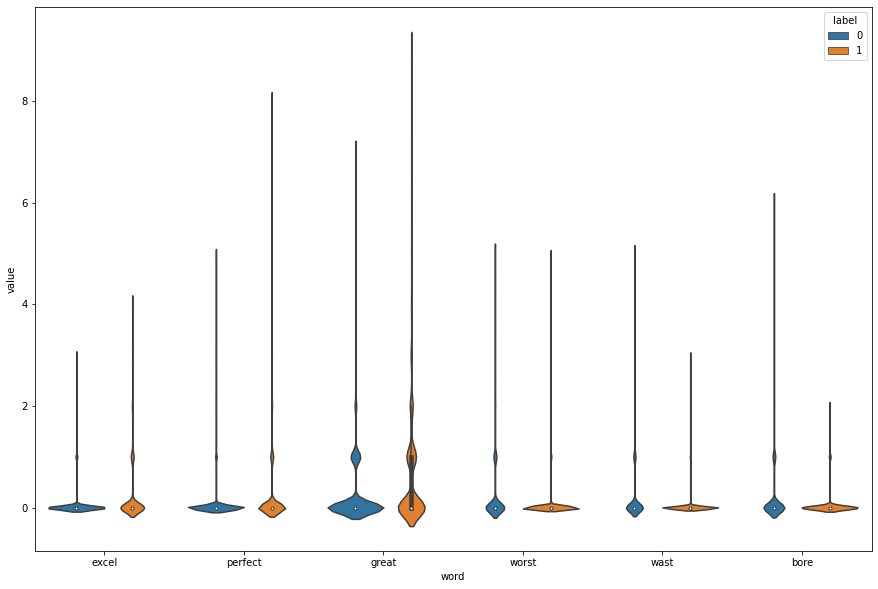

In [30]:
plt.figure(figsize=(15,10))
sns.violinplot(x = data_plot_long.word, y = data_plot_long.value, hue = data_plot_long.label);

### Singular Value Decomposition

---

Entrenemos una regresión logística que use como features el resultado de SVD.

In [32]:
feature_to_coef.shape

(28167, 2)

El modelo anterior fue entrenado con más de 50 mil features!

Veamos cómo cambia la performance seleccionando 200 features.

In [33]:

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 200);

X_train_svd = svd.fit_transform(X_train)


In [34]:
X_test_svd = svd.transform(X_test)

In [37]:
X_train_svd_train, X_train_svd_val, y_train_train, y_train_val = \
    train_test_split(X_train_svd, y_train, train_size = 0.75, shuffle = True, random_state = 147)

for c in [0.005, 0.008, 0.009, 0.01, 0.05, 0.07, 0.1, 0.3, 0.5, 0.8, 1, 2, 5]:    
    lr = LogisticRegression(C=c, solver="newton-cg", penalty="l2")    
    lr.fit(X_train_svd_train, y_train_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_train_val, lr.predict(X_train_svd_val))))
    

Accuracy for C=0.005: 0.8323736404350608
Accuracy for C=0.008: 0.8349328214971209
Accuracy for C=0.009: 0.8374920025591811
Accuracy for C=0.01: 0.836852207293666
Accuracy for C=0.05: 0.8413307741522713
Accuracy for C=0.07: 0.8432501599488164
Accuracy for C=0.1: 0.8445297504798465
Accuracy for C=0.3: 0.8438899552143314
Accuracy for C=0.5: 0.8432501599488164
Accuracy for C=0.8: 0.8432501599488164
Accuracy for C=1: 0.8426103646833013
Accuracy for C=2: 0.8426103646833013
Accuracy for C=5: 0.8419705694177864


In [38]:
final_model_svd = LogisticRegression(C = 0.1, solver="newton-cg", penalty="l2")
final_model_svd.fit(X_train_svd, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_model_svd.predict(X_test_svd)))
print ("Final Confusion Matrix: \n %s" 
        % confusion_matrix(y_test, final_model_svd.predict(X_test_svd)))

Final Accuracy: 0.83728
Final Confusion Matrix: 
 [[2605  528]
 [ 489 2628]]


## N-gramas

---

Hasta ahora usamos sólo features compuestas por una sola palabra en nuestro modelo, que llamamos **1-grama** o **unigrama**. 

Potencialmente, podemos agregar más poder predictivo a nuestro modelo agregando también **secuencias de dos o tres palabras (bigramas o trigramas)**. 

Por ejemplo, si una reseña tuviera la secuencia de tres palabras "no me gustó la película", solo consideraríamos estas palabras individualmente con un modelo de unigramas y probablemente no captaríamos que se trata de un sentimiento negativo porque la palabra "gustó" en sí misma va a estar altamente correlacionado con una revisión positiva.

Scikit-learn hace que sea muy fácil construir estas features. 

Simplemente usamos el argumento `ngram_range` con cualquiera de las clases "Vectorizador".

In [39]:
count_vectorizer_bigram = CountVectorizer(ngram_range = (1, 2))
count_vectorizer_bigram.fit(clean_train)
X_train_bigram_sparse = count_vectorizer_bigram.transform(clean_train)
X_test_bigram_sparse = count_vectorizer_bigram.transform(clean_test)

#X_train_bigram = pd.DataFrame(X_train_bigram_sparse.todense(), 
#             columns = count_vectorizer_bigram.get_feature_names()) 
             
#X_test_bigram = pd.DataFrame(X_test_bigram_sparse.todense(), 
#             columns = count_vectorizer_bigram.get_feature_names()) 

#usamos las matrices esparsas porque rompe si trato de convertrlas en densas para esta cantidad de features
X_train_bigram_train, X_train_bigram_val, y_train_train, y_train_val = \
    train_test_split(X_train_bigram_sparse, y_train, train_size = 0.75, shuffle = True, random_state = 147)

for c in [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:    
    lr = LogisticRegression(C=c, solver="newton-cg", penalty="l2")    
    lr.fit(X_train_bigram_train, y_train_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_train_val, lr.predict(X_train_bigram_val))))


Accuracy for C=0.01: 0.8515674984005118
Accuracy for C=0.05: 0.8656429942418427
Accuracy for C=0.1: 0.8662827895073576
Accuracy for C=0.25: 0.8643634037108126
Accuracy for C=0.5: 0.8694817658349329
Accuracy for C=0.6: 0.8688419705694178
Accuracy for C=0.7: 0.8688419705694178
Accuracy for C=0.8: 0.8694817658349329
Accuracy for C=0.9: 0.8688419705694178
Accuracy for C=1: 0.8688419705694178


In [40]:
from pprint import pprint

count_vectorizer = CountVectorizer()
count_vectorizer.fit(clean_train)

count_vectorizer_bigram = CountVectorizer(ngram_range = (1, 2))
count_vectorizer_bigram.fit(clean_train)

print (len(count_vectorizer_bigram.vocabulary_))
print (len(count_vectorizer.vocabulary_))

#pprint(count_vectorizer.vocabulary_)


516596
28167


In [41]:
final_model_bigram = LogisticRegression(C = 0.25, solver="newton-cg", penalty="l2")
final_model_bigram.fit(X_train_bigram_sparse, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_model_bigram.predict(X_test_bigram_sparse)))    
print ("Final Confusion Matrix: \n %s" 
        % confusion_matrix(y_test, final_model_bigram.predict(X_test_bigram_sparse)))

Final Accuracy: 0.86368
Final Confusion Matrix: 
 [[2670  463]
 [ 389 2728]]


<div class="div-dhds-fondo-1"> Conclusiones
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_47_Text_Mining_2/Presentacion/img/M6_CLASE_47_separador.png" align="center" />

</div>

* Construimos un modelo de clasificación de textos empleando los algoritmos que ya conocíamos.

* Construimos el conjunto de features del modelo transformando los inputs (textos) mediante las técnicas de preprocesamiento que vimos en la clase pasada.

* Evaluamos la performance del modelo del mismo modo que lo hacemos con cualquier modelo de clasificación.


<div class="div-dhds-fondo-1"> Hands-on
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_47_Text_Mining_2/Presentacion/img/M6_CLASE_47_separador.png" align="center" />

</div>


## Ejercicio

---

TF-IDF es mejor que CountVectorizer porque no sólo se centra en la frecuencia de las palabras presentes en el corpus, sino que también tiene en cuenta su importancia. 

Volvamos a entrenar una regresión logísticas usando como features la representación tf-idf de unigramas, bigramas y trigramas.

Veamos cuáles son los n-gramas más discriminantes.


## Solución

---

In [68]:
from sklearn.feature_extraction.text import TfidfTransformer

In [69]:
count_vectorizer = CountVectorizer(ngram_range = (2, 3))
count_vectorizer.fit(clean_train)
X_train_sparse = count_vectorizer.transform(clean_train)
X_test_sparse = count_vectorizer.transform(clean_test)

In [70]:
transformer = TfidfTransformer()

X_train_ngram_encoding = transformer.fit_transform(X_train_sparse);

X_test_ngram_encoding = transformer.transform(X_test_sparse);


In [71]:
X_train_ngram_train, X_train_ngram_val, y_train_train, y_train_val = \
    train_test_split(X_train_ngram_encoding, y_train, train_size = 0.75, shuffle = True, random_state = 147)

for c in [0.05, 0.25, 0.5, 0.7, 0.8, 0.9, 1]:    
    lr = LogisticRegression(C=c, solver="newton-cg", penalty="l2")    
    lr.fit(X_train_ngram_train, y_train_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_train_val, lr.predict(X_train_ngram_val))))


Accuracy for C=0.05: 0.4990403071017274
Accuracy for C=0.25: 0.5930902111324377
Accuracy for C=0.5: 0.6647472808701216
Accuracy for C=0.7: 0.689699296225208
Accuracy for C=0.8: 0.6935380678182982
Accuracy for C=0.9: 0.6973768394113884
Accuracy for C=1: 0.6992962252079334


In [72]:
final_model_tfidf = LogisticRegression(C = 1, solver="newton-cg", penalty="l2")
final_model_tfidf.fit(X_train_ngram_encoding, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_model_tfidf.predict(X_test_ngram_encoding)))
print ("Final Confusion Matrix: \n %s" 
        % confusion_matrix(y_test, final_model_tfidf.predict(X_test_ngram_encoding)))

Final Accuracy: 0.78592
Final Confusion Matrix: 
 [[2461  665]
 [ 673 2451]]


In [73]:
feature_to_coef = pd.DataFrame(columns = ['ngram', 'coef'])
feature_to_coef.ngram = count_vectorizer.get_feature_names()
feature_to_coef.coef = final_model_tfidf.coef_[0]
feature_to_coef_sort_desc = feature_to_coef.sort_values(by = 'coef', ascending = False)
feature_to_coef_sort_desc.ngram[0:35]

c:\Users\Ionatan\anaconda3\envs\DH\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


757176           one best
473220         great movi
634891          love movi
502468     high recommend
720695           must see
284                 10 10
758927        one favorit
472475         great film
1167083        well worth
472905          great job
409342         first time
1164395         well done
635693         love stori
865311        realli good
107778          best movi
328798         enjoy movi
378444       favorit movi
865832        realli like
107294          best film
1194316        would love
132955        br br great
138332           br great
370592        famili movi
395947          film noir
267417      definit worth
1090434         top notch
870816     recommend movi
344022        even though
117404        black white
393097         film great
865416       realli great
708748          movi show
408946          first saw
394859          film made
1201991        year later
Name: ngram, dtype: object

In [74]:
feature_to_coef_sort_asc = feature_to_coef.sort_values(by = 'coef', ascending = True)
feature_to_coef_sort_asc.ngram[0:25]


1152513          wast time
1191048         worst movi
88449             bad movi
627168           look like
131776               br br
764379           one worst
1191056    worst movi ever
86713              bad act
699201            movi bad
1190903         worst film
864225          realli bad
346665           ever seen
701861           movi ever
648750           make movi
376127        fast forward
937226           seem like
87633             bad film
636612          low budget
649696           make sens
713073         much better
699756          movi br br
699755             movi br
514028         horror movi
344566           even wors
701918      movi ever seen
Name: ngram, dtype: object

Vemos que los n-grams más discriminantes son unigramas

<div class="div-dhds-fondo-1"> Referencias y material adicional
<img src="https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_2021_img/master/M6/CLASE_47_Text_Mining_2/Presentacion/img/M6_CLASE_47_separador.png" align="center" />

</div>

<a href="https://towardsdatascience.com/how-to-build-a-twitter-sentiment-analysis-system-12b28dcbae56" target="_blank">How to Build a Twitter Sentiment Analysis System</a>

<a href="https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184" target="_blank">Sentiment Analysis with Python (Part 1)</a>

<a href="https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a" target="_blank">Sentiment Analysis with Python (Part 2)</a>

<a href="https://towardsdatascience.com/imdb-reviews-or-8143fe57c825" target="_blank">Performing Sentiment Analysis on Movie Reviews</a>

<a href="https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews" target="_blank">Sentiment Analysis of IMDB Movie Reviews</a>  
        